In [29]:
import cv2
import os
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
from pathlib import Path
import plotly.express as px
from sklearn.decomposition import PCA

In [3]:
def load_data(dir_path, IMG_SIZE):
   
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path +'/'+ path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + '/'+ path + '/' + file)
                    img
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [31]:
TRAIN_DIR = ('imagedata/Training/Training')
TEST_DIR = ('imagedata/Testing/Testing')
OUTPUT_DIR = Path('output')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
reducedtrainfile = (OUTPUT_DIR / 'reducetrain.pickle')
reducedtestfile = (OUTPUT_DIR / 'reducetest.pickle')

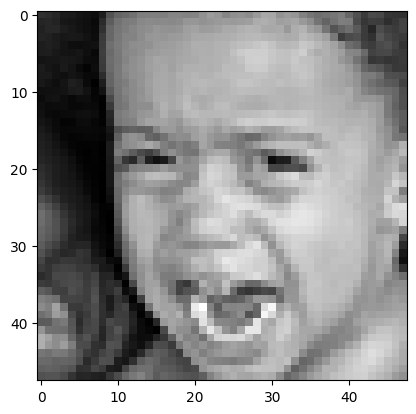

In [5]:
path = sorted(os.listdir(TEST_DIR))
file = os.listdir(TEST_DIR +'/'+ path[1])
img = cv2.imread(TEST_DIR + '/'+ path[1] + '/' + file[1])

IMG_SIZE= (48, 48)
plt.imshow(img)

In [6]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


28273 images loaded from imagedata/Training/Training directory.


100%|██████████| 7/7 [00:01<00:00,  5.91it/s]

7067 images loaded from imagedata/Testing/Testing directory.


In [7]:
X_train[0,0,0]

array([1., 1., 1.], dtype=float32)

In [8]:

originalx_train050 = X_train[0,5,0]
originalx_train008 = X_train[0,0,8]

In [9]:
originalx_train050,originalx_train008

(array([0.4862745, 0.4862745, 0.4862745], dtype=float32),
 array([1., 1., 1.], dtype=float32))

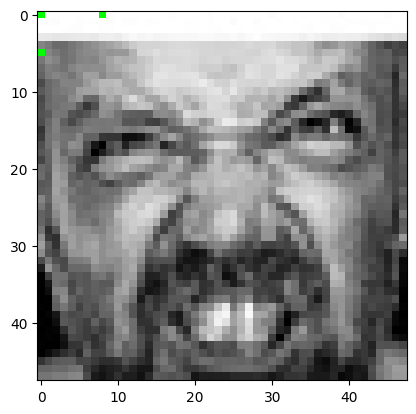

In [10]:
X_train[0,0,0] = [0,1,0]
X_train[0,5,0] = [0,1,0]
X_train[0,0,8] = [0,1,0]
plt.imshow(X_train[0])

We can see that our data is broken into a 4 dimentional matrix, with:
- First layer being the picture id
- second layer representing each column of the picture (len48)
- third layer representing each row withing that column (len48)
- 4th layer a len 3 vector representing the pixel value of each pixel

Reverting picture to original state:


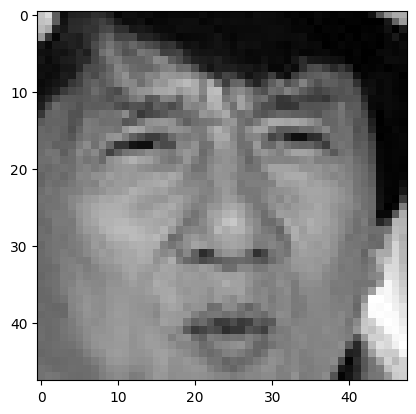

In [11]:
plt.imshow(X_train[3])

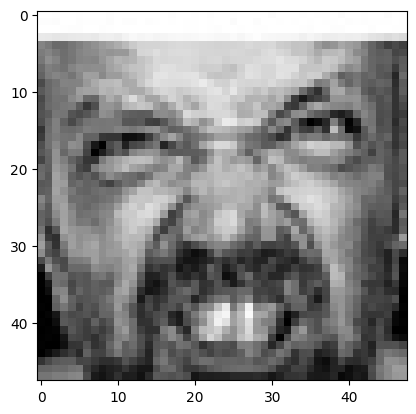

In [12]:
X_train[0,0,0]= [1,1,1]
X_train[0,5,0]= [0.4862745, 0.4862745, 0.4862745]
X_train[0,0,8]= [1., 1., 1.]
plt.imshow(X_train[0])

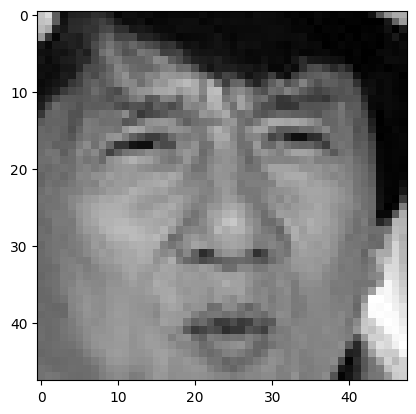

In [13]:
c = cv2.imread(TRAIN_DIR + '/'+ path[1] + '/' + file[0])
plt.imshow(c)

In [14]:
len(X_train) +len(X_test)
len(X_train)/(len(X_train) +len(X_test))

0.8000282965478211

In [15]:
train_labels

{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}

In [16]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([3995, 4097, 7215, 4965, 4830, 3171]))

In [17]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 958, 1024, 1774, 1233, 1247,  831]))

In [18]:
#create a function to reduce dimentionality of dataset
def reduce_array(dataset):
    newdataset = np.zeros((len(dataset),len(dataset[0]),len(dataset[0,0])))
    for i in tqdm(range(len(dataset))):
        for j in range(len(dataset[i])):
            for k in range(len(dataset[i,j])):
                newdataset[i,j,k] = dataset[i,j,k].mean()
    return newdataset

In [19]:
X_train[3,4,2].mean()

0.101960786

In [33]:

if reducedtrainfile.is_file():
    with open(reducedtrainfile, "rb") as f:
      reducetrain = pickle.load(f)
else: 
    reducetrain = reduce_array(X_train)
    with open(reducedtrainfile, "wb") as f:
      pickle.dump(reducetrain, f)

In [32]:

if reducedtestfile.is_file():
    with open(reducedtestfile, "rb") as f:
      reducetest = pickle.load(f)
else: 
    reducetest = reduce_array(X_test)
    with open(reducedtestfile, "wb") as f:
      pickle.dump(reducetest, f)

100%|██████████| 7067/7067 [01:41<00:00, 69.40it/s]


In [ ]:
reducetest = reduce_array(X_test)

100%|██████████| 7067/7067 [01:41<00:00, 69.30it/s]


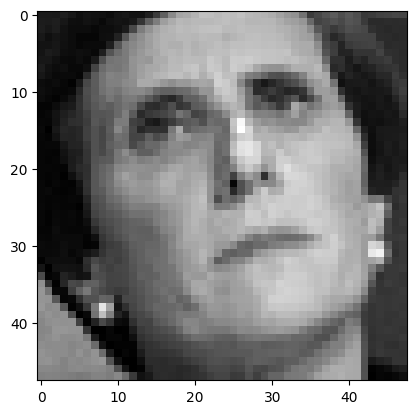

In [143]:
plt.imshow(reducetest[0], cmap='gray')

In [34]:
def plotpixels(dataset):
    newshape = (len(dataset)*len(dataset[0])*len(dataset[0,0]))
    pixelset = np.reshape(dataset, newshape)
    fig = px.histogram(pixelset, nbins=50)
    fig.show()


In [159]:
len(reducetest[0,0])

48

In [156]:
7067*48*48

16282368

#pixels per images


In [ ]:
imagepca = PCA(n_components=2304)
imagepca.fit(X_train)